# Import requirements

In [ ]:
!pip install --upgrade gensim
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=28bce0214af380a8b4ddc40add0093d0c183cfe39f79414bb6c75e78f747d388
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
import random
import time
import gensim.downloader
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, ParameterGrid
from keras.models import Sequential
from keras.layers import Embedding, LSTM, TimeDistributed, Dense, Bidirectional
from keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from seqeval.metrics import f1_score
import tensorflow as tf

np.random.seed(50)
tf.random.set_seed(50)

In [ ]:
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Question 1.1
> **Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word and its cosine similarity.**

In [ ]:
words = ["student", "Apple", "apple"]

for word in words:
    similar_word, cos_similarity = w2v.most_similar(word)[0]  #index 0 gives us the most similar word
    print(f"The most similar word to \"{word}\" is: \"{similar_word}\", with a cosine similarity of: {cos_similarity}")

The most similar word to "student" is: "students", with a cosine similarity of: 0.7294867038726807
The most similar word to "Apple" is: "Apple_AAPL", with a cosine similarity of: 0.7456986308097839
The most similar word to "apple" is: "apples", with a cosine similarity of: 0.720359742641449


# Question 1.2

## Preprocessing

In [ ]:
def read_data(file_name):
  sentences = []
  ner_tags_combined = []

  temp_words = []
  temp_ner_tags = []

  with open(file_name, 'r') as f:
      for line in f:
          tokens = line.strip().split()

          if not tokens:
              sentences.append(" ".join(temp_words))
              ner_tags_combined.append(" ".join(temp_ner_tags))

              temp_words.clear()
              temp_ner_tags.clear()
              continue

          if tokens[0] == '"' and tokens[1] == '"':
              temp_words.append('"')
              temp_ner_tags.append(tokens[3])
          else:
              temp_words.append(tokens[0])
              temp_ner_tags.append(tokens[3])

  df = pd.DataFrame({
      'sentence': sentences,
      'NER_tags': ner_tags_combined
  })
  df['length'] = df['sentence'].apply(lambda x: len(x.split(" ")))
  return df

In [ ]:
train = read_data("eng.train")
val = read_data("eng.testa")
test = read_data("eng.testb")

## Part a)
> **Describe the size (number of sentences) of the training, development and test file for CoNLL2003. Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO, etc.) you chose.**

In [ ]:
train_size = len(train)
val_size = len(val)
test_size = len(test)

print(f"Number of sentences in the training set: {train_size}")
print(f"Number of sentences in the development set: {val_size}")
print(f"Number of sentences in the test set: {test_size}")

unique_labels_train, unique_labels_val, unique_labels_test, unique_labels_overall = set(), set(), set(), set()

def update_unique_labels(df, unique_set):
    for label_str in df['NER_tags']:
        labels = label_str.split()
        unique_set.update(labels)

update_unique_labels(train, unique_labels_train)
update_unique_labels(val, unique_labels_val)
update_unique_labels(test, unique_labels_test)

unique_labels_overall.update(unique_labels_train)
unique_labels_overall.update(unique_labels_val)
unique_labels_overall.update(unique_labels_test)

print()
print("Unique labels in train:", unique_labels_train)
print("Unique labels in val:", unique_labels_val)
print("Unique labels in test:", unique_labels_test)
print("Unique labels overall:", unique_labels_overall)


Number of sentences in the training set: 14986
Number of sentences in the development set: 3465
Number of sentences in the test set: 3683

Unique labels in train: {'B-MISC', 'I-MISC', 'I-PER', 'I-LOC', 'B-ORG', 'B-LOC', 'O', 'I-ORG'}
Unique labels in val: {'B-MISC', 'I-MISC', 'I-PER', 'I-LOC', 'O', 'I-ORG'}
Unique labels in test: {'B-MISC', 'I-MISC', 'I-PER', 'I-LOC', 'B-ORG', 'B-LOC', 'O', 'I-ORG'}
Unique labels overall: {'B-MISC', 'I-MISC', 'I-PER', 'I-LOC', 'B-ORG', 'B-LOC', 'O', 'I-ORG'}


## Part b)
> ** Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word. Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.**

In [ ]:
sentence_str = train.loc[116]['sentence']
NER_tags_str = train.loc[116]['NER_tags']

word_list = sentence_str.split(" ")
NER_tags_list = NER_tags_str.split(" ")

max_word_length = max(len(word) for word in word_list)

for word, tag in zip(word_list, NER_tags_list):
    print(f"{word: <{max_word_length}} {tag}")

Tension   O
has       O
mounted   O
since     O
Israeli   I-MISC
Prime     O
Minister  O
Benjamin  I-PER
Netanyahu I-PER
took      O
office    O
in        O
June      O
vowing    O
to        O
retain    O
the       O
Golan     I-LOC
Heights   I-LOC
Israel    B-LOC
captured  O
from      O
Syria     I-LOC
in        O
the       O
1967      O
Middle    I-LOC
East      I-LOC
war       O
.         O


*   Israeli is labeled as "I-MISC". Since it's not preceded by another "I-MISC" or "B-MISC", it forms a single-word named entity of type "MISC".

*   Benjamin Netanyahu is labeled as "I-PER" for both words. The successive "I-PER" tags tell us to concatenate these words into a single named entity of type "PER".

*   Golan Heights is labeled as "I-LOC" for both words. Like "Benjamin Netanyahu", the successive "I-LOC" tags mean we should concatenate these into a single named entity of type "LOC".

*   Israel is labeled as "B-LOC", indicating the start of a new named entity of type "LOC". Since it's not followed by an "I-LOC", it's a single-word named entity.

*   Syria is labeled as "I-LOC". It's not preceded by another "I-LOC" or "B-LOC", so it's a single-word named entity of type "LOC".

*   Middle East is labeled as "I-LOC" for both words. The successive "I-LOC" tags mean these words form a single named entity of type "LOC".

Here are the named entities in the example sentence:

1.   Israeli (MISC)
1.   Benjamin Netanyahu (PER)
1.   Golan Heights (LOC)
1.   Israel (LOC)
1.   Syria (LOC)
1.   Middle East (LOC)





# Question 1.3

## Preprocessing

In [ ]:
#to find the longest sequence
print("longest sentence in training:", max(train['length']))
print("longest sentence in development:", max(val['length']))
print("longest sentence in testing:", max(test['length']))

longest sentence in training: 113
longest sentence in development: 109
longest sentence in testing: 124


In [ ]:
train_sentences = train['sentence'].tolist()
train_ner_tags = train['NER_tags'].tolist()
val_sentences = val['sentence'].tolist()
val_ner_tags = val['NER_tags'].tolist()
test_sentences = test['sentence'].tolist()
test_ner_tags = test['NER_tags'].tolist()

In [ ]:
word_tokenizer = Tokenizer(filters=[], lower=False, oov_token='OOV')  #tried keeping the case vs change all of them to lower case, ~10% increment in validation f1 score and 5% increment in testing f1 score
word_tokenizer.fit_on_texts(train_sentences)

tag_tokenizer = Tokenizer(filters=[],lower=False)
tag_tokenizer.fit_on_texts(train_ner_tags)

#post-padded to 124 as the longest sequence in all the data is 124
X_train = pad_sequences(word_tokenizer.texts_to_sequences(train_sentences), maxlen=124, padding='post')
Y_train = pad_sequences(tag_tokenizer.texts_to_sequences(train_ner_tags), maxlen=124, padding='post')

X_val = pad_sequences(word_tokenizer.texts_to_sequences(val_sentences), maxlen=124, padding='post')
Y_val = pad_sequences(tag_tokenizer.texts_to_sequences(val_ner_tags), maxlen=124, padding='post')

X_test = pad_sequences(word_tokenizer.texts_to_sequences(test_sentences), maxlen=124, padding='post')
Y_test = pad_sequences(tag_tokenizer.texts_to_sequences(test_ner_tags), maxlen=124, padding='post')

#create embedding matrix with w2v
vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_tokenizer.word_index.items():
    try:
        embedding_vector = w2v[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        continue
oov_idx = word_tokenizer.word_index.get('OOV', 0)
if oov_idx != 0:
    embedding_matrix[oov_idx] = np.zeros(embedding_dim)

tag_tokenizer.index_word[0] = 'PAD'
tag_tokenizer.index_word

{1: 'O',
 2: 'I-PER',
 3: 'I-ORG',
 4: 'I-LOC',
 5: 'I-MISC',
 6: 'B-MISC',
 7: 'B-ORG',
 8: 'B-LOC',
 0: 'PAD'}

## Model training

The hyperparameters for the following model have been tuned through grid-search.


*   Bidirection LSTM (100 units, batchsize 16, adam. starting learning rate 0.01 with learning rate reduction of factor 0.2 with patience of 3)
*   remove padding for f1 evaluation via seqeval
*   Custom earlystopper (based on validation F1 score with patience 5)




In [ ]:
start_time = time.time()
best_f1 = 0.0
patience_counter = 0
f1_list = []

#remove padding from evaluation
def remove_padding(y_true, y_pred):
    # print(y_true[0])
    # print(y_pred[0])
    y_true_no_pad = []
    y_pred_no_pad = []
    for true_seq, pred_seq in zip(y_true, y_pred):
        true_no_pad = [tag for tag in true_seq if tag != 'PAD']
        pred_no_pad = [tag for i, tag in enumerate(pred_seq) if true_seq[i] != 'PAD']
        y_true_no_pad.append(true_no_pad)
        y_pred_no_pad.append(pred_no_pad)
    # print(y_true_no_pad[0])
    # print(y_pred_no_pad[0])
    return y_true_no_pad, y_pred_no_pad

#early stopping when f1 on development set is no longer increasing
def on_epoch_end(epoch, logs):
    global best_f1, patience_counter, f1_list

    Y_pred = model.predict(X_val)
    pred_tags = [[tag_tokenizer.index_word[np.argmax(y)] for y in pred] for pred in Y_pred]
    val_tags = [[tag_tokenizer.index_word[y] for y in val] for val in Y_val]
    val_tags_no_pad, pred_tags_no_pad = remove_padding(val_tags, pred_tags)
    current_f1 = f1_score(val_tags_no_pad, pred_tags_no_pad)

    print(f"Epoch {epoch + 1}, F1 Score: {current_f1}")
    f1_list.append([epoch + 1, current_f1])

    if current_f1 > best_f1:
        best_f1 = current_f1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:  #patience =5
            print(f"Early stopping. Best F1 Score: {best_f1}")
            patience_counter = 0
            model.stop_training = True

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], trainable=False, mask_zero=True)) #trainable set to false to keep matrix frozen

model.add(Bidirectional(LSTM(units=100, return_sequences=True)))

model.add(TimeDistributed(Dense(len(tag_tokenizer.word_index) + 1, activation='softmax')))

custom_adam = Adam(learning_rate=0.01)

model.compile(optimizer=custom_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

f1_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(X_train, Y_train.reshape(*Y_train.shape, 1),
                    batch_size=16, epochs=50,
                    validation_data=(X_val, Y_val.reshape(*Y_val.shape, 1)),
                    callbacks=[reduce_lr, f1_callback])

end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime: {total_time} seconds")

Epoch 1/50
109/109 [==============================] - 3s 4ms/step
Epoch 1, F1 Score: 0.7749030920400253
937/937 [==============================] - 26s 19ms/step - loss: 0.1186 - accuracy: 0.9683 - val_loss: 0.1549 - val_accuracy: 0.9575 - lr: 0.0100
Epoch 2/50
109/109 [==============================] - 0s 4ms/step
Epoch 2, F1 Score: 0.8166965888689408
937/937 [==============================] - 12s 13ms/step - loss: 0.0561 - accuracy: 0.9844 - val_loss: 0.1383 - val_accuracy: 0.9632 - lr: 0.0100
Epoch 3/50
109/109 [==============================] - 0s 4ms/step
Epoch 3, F1 Score: 0.8042976380749423
937/937 [==============================] - 12s 13ms/step - loss: 0.0369 - accuracy: 0.9897 - val_loss: 0.1441 - val_accuracy: 0.9621 - lr: 0.0100
Epoch 4/50
109/109 [==============================] - 0s 4ms/step
Epoch 4, F1 Score: 0.8242381289865344
937/937 [==============================] - 13s 13ms/step - loss: 0.0258 - accuracy: 0.9926 - val_loss: 0.1507 - val_accuracy: 0.9651 - lr: 0.0100


In [ ]:
Y_pred = model.predict(X_test)

pred_tags = [[tag_tokenizer.index_word[np.argmax(y)] for y in pred] for pred in Y_pred]
test_tags = [[tag_tokenizer.index_word.get(y, 'PAD') for y in true] for true in Y_test]
test_tags_no_pad, pred_tags_no_pad = remove_padding(test_tags, pred_tags)

print("Test F1 Score:", f1_score(test_tags_no_pad, pred_tags_no_pad))

116/116 [==============================] - 0s 4ms/step
Test F1 Score: 0.7383709891779001


## Part a)


>  **Discuss how you deal with new words in the training set which are not found in the pretrained dictionary. Likewise, how do you deal with new words in the test set which are not found in either the pretrained dictionary or the training set? Show the corresponding code snippet.**

```
word_tokenizer = Tokenizer(filters=[], lower=False, oov_token='OOV')

for word, idx in word_tokenizer.word_index.items():
    try:
        embedding_vector = w2v[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        continue
oov_idx = word_tokenizer.word_index.get('OOV', 0)
if oov_idx != 0:
    embedding_matrix[oov_idx] = np.zeros(embedding_dim)
```

For training, validation and testing sets, words that are not in the pre-trained dictionary, they are represented by 'OOV' (Out-Of-Vocabulary) token which are converted to zero vectors.



## Part b)

>  **Describe what neural network you used to produce the final vector representation of each word and what are the mathematical functions used for the forward computation (i.e., from the pretrained word vectors to the final label of each word).**

The architecture used for generating the final vector representation of each word is a Sequential model comprised of the following layers:

1. **Embedding Layer**: This layer converts token indices to vectors of fixed size, 300 in this case. The weight of this layer is initialized with pre-trained vectors and is kept frozen during training (trainable=False).

2. **Bidirectional LSTM Layer**: This layer has 100 LSTM units and returns sequences, effectively doubling the output dimensions due to its bidirectional nature (100 units in each direction).

3. **TimeDistributed Dense Layer**: This layer has a number of output units equal to len(tag_tokenizer.word_index) + 1, 9 in this case, each applying a softmax activation function.

**Mathematical functions**
1. **Embedding Layer**: Vector lookup

2. **Bidirectional LSTM Layer**: LSTM cell operations (sigmoid and tanh activations)

3. **TimeDistributed Dense Layer**: Linear transformation followed by a softmax activation.


---
---
> **Give the detailed setting of the network including which parameters are being updated, what are their sizes, and what is the length of the final vector representation of each word to be fed to the softmax classifier.**

```
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], trainable=False, mask_zero=True))
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag_tokenizer.word_index) + 1, activation='softmax')))

custom_adam = Adam(learning_rate=0.01)

model.compile(optimizer=custom_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

f1_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(X_train, Y_train.reshape(*Y_train.shape, 1),
                    batch_size=16, epochs=50,
                    validation_data=(X_val, Y_val.reshape(*Y_val.shape, 1)),
                    callbacks=[reduce_lr, f1_callback])

```


**Network settings**

Embedding layer:
- Parameters being updated: None (**Non-trainable**)
- Size: vocabulary size (23626) x embedding dimension (300) = **7,087,800**

Bidirectional LSTM Layer:
- Parameters veing updated: Weights and biases in the forward and backward LSTM units
- Size: 4 * ((size_of_input + 1) * size_of_output + size_of_output^2), which in this case would be 4 * ((300 + 1) * 100 + 100^2) = 4 * (30100 + 10000) = 4 * 40100 = 160400. Because it's bidirectional, this number is doubled: 160,400 * 2 = **320,800**

TimeDistributed dense layer (softmax classifier):

- Parameters being updated: Weights and biases in the dense layer
- Size: output dimension of the previous layer (200) times the output dimension of this layer (9) plus the bias terms for each output node (9). That is, (200 * 9) + 9 = **1809**


**Additional Information**
- Batch size: 16
- Optimizer: Adam with a custom learning rate of 0.01
- Loss function: Sparse categorical cross-entropy
- Other callbacks: Reduce learning rate by factor of 0.2 on plateau with patience of 3, custom F1 score calculation for early stopping with patience of 5


**Final cector Representation**

- Length of final vector: 9, corresponding to the 8 unique NER tags and the 'PAD' tag. Each element of this vector will represent the probability that the input word belongs to one of these 9 classes.







In [ ]:
|model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         7087800   
                                                                 
 bidirectional (Bidirection  (None, None, 200)         320800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, None, 9)           1809      
 ributed)                                                        
                                                                 
Total params: 7410409 (28.27 MB)
Trainable params: 322609 (1.23 MB)
Non-trainable params: 7087800 (27.04 MB)
_________________________________________________________________


## Part c)


> **Report how many epochs you used for training, as well as the running time**


The model is set to run for a **maximum of 50 epochs**, but early stopping is implemented based on the F1 score on the development set. If the F1 score doesn't improve for 5 consecutive epochs, the training will stop. In this case it took **11 epochs**

## Part d)
> **Report the f1 score on the test set, as well as the f1 score on the development set for each epoch during training.**

Total training time: 152.8239767551422 seconds

F1 score on test set: 0.7383709891779001

Epoch: 1, F1 Score: 0.7749030920400253
Epoch: 2, F1 Score: 0.8166965888689408
Epoch: 3, F1 Score: 0.8042976380749423
Epoch: 4, F1 Score: 0.8242381289865344
Epoch: 5, F1 Score: 0.8183976783044588
Epoch: 6, F1 Score: 0.8266196562362274
Epoch: 7, F1 Score: 0.8247750132345157
Epoch: 8, F1 Score: 0.8227112676056338
Epoch: 9, F1 Score: 0.8223144143348927
Epoch: 10, F1 Score: 0.8211827007943513
Epoch: 11, F1 Score: 0.8219904543044017


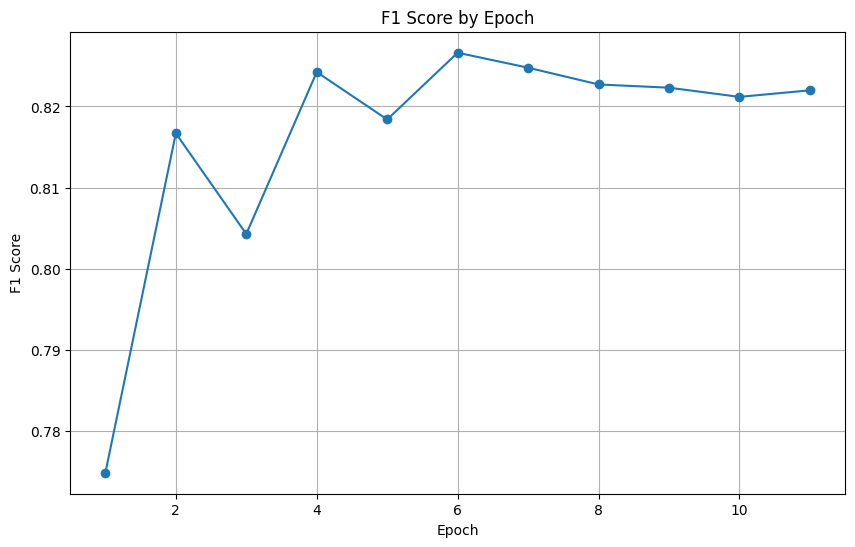

In [ ]:
print(f"Total training time: {total_time} seconds")
print()
print(f"F1 score on test set: {f1_score(test_tags_no_pad, pred_tags_no_pad)}")
print()
for epoch, f1 in f1_list:
    print(f"Epoch: {epoch}, F1 Score: {f1}")

import matplotlib.pyplot as plt

epochs, f1s = zip(*f1_list)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1s, marker='o')
plt.title('F1 Score by Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()